In [138]:
import pandas as pd
from gurobi import *
import matplotlib.pyplot as plt
import math
import numpy as np

In [139]:
booking = pd.read_excel("/media/luckshan/New Volume/AirCargo/Ab-Ovo Project/Ab Ovo Data/Booking_new.xlsx")
bd_zones = pd.read_excel("/media/luckshan/New Volume/AirCargo/Ab-Ovo Project/Ab Ovo Data/BreakDownZones.xlsx")
dz_to_bd = pd.read_excel("/media/luckshan/New Volume/AirCargo/Ab-Ovo Project/Ab Ovo Data/DistanceMatrixDropZoneToBreakDownZone.xlsx")
drop_zones = pd.read_excel("/media/luckshan/New Volume/AirCargo/Ab-Ovo Project/Ab Ovo Data/DropZones.xlsx")
bu_zones = pd.read_excel("/media/luckshan/New Volume/AirCargo/Ab-Ovo Project/Ab Ovo Data/Outbound.xlsx", sheet_name='BU Zones')
bu_zones_workstations = pd.read_excel("/media/luckshan/New Volume/AirCargo/Ab-Ovo Project/Ab Ovo Data/Outbound.xlsx", sheet_name='WorkStation')
bu_zones_to_flight = pd.read_excel("/media/luckshan/New Volume/AirCargo/Ab-Ovo Project/Ab Ovo Data/Outbound.xlsx", sheet_name='FlightNumber-BUZone')
flight_default_processing = pd.read_excel("/media/luckshan/New Volume/AirCargo/Ab-Ovo Project/Ab Ovo Data/Outbound.xlsx", sheet_name='DefaultProcessingTime')
flight_pre_processing = pd.read_excel("/media/luckshan/New Volume/AirCargo/Ab-Ovo Project/Ab Ovo Data/Outbound.xlsx", sheet_name='Pre-ProcessingBufferTime')

In [140]:
booking.head()

,Shipment ID,FlightDate,ShipmentArrivalDateUTC,ProductName,ShipmentOrigin,ShipmentDestination,CarrierCode,Priority,DropZone,FlightNumberArrival,...,Weight,Volume,BookingStatus,WeighCMMit,VolumeUnit,TotalVolume,TotalWeight,TotalNumberOfPieces,FlightNumberDeparture,ShipmentDepartureDateUTC
0,020-77215633,2018-10-23,2018-10-23T06:10:00,NRML,BBB,ACC,ZZ,False,DZ NRML-2,1,...,26.2,0.08,C,K,B,0.08,26.2,1,3,2018-10-25T05:15:00
1,020-77215515,2018-10-23,2018-10-23T06:10:00,NRML,BBB,ADD,ZZ,False,DZ NRML-2,1,...,5.5,0.02,C,K,B,0.02,5.5,1,4,2018-10-27T13:45:00
2,020-84100306,2018-10-23,2018-10-23T06:10:00,NML,BBB,AGG,ZZ,False,DZ NML-1,1,...,2.6,0.01,C,K,B,0.01,2.6,1,7,2018-10-24T21:20:00
3,020-82036091,2018-10-23,2018-10-23T06:10:00,NRML,BBB,AII,ZZ,False,DZ NRML-2,1,...,1.7,0.01,C,K,B,0.01,1.7,1,9,2018-10-27T17:20:00
4,020-84368815,2018-10-23,2018-10-23T06:10:00,NRML,BBB,CCC,ZZ,False,DZ NRML-2,1,...,22.6,0.26,C,K,B,0.26,22.6,1,46,2018-10-24T23:00:00


In [141]:
bd_zones.head()

,Description,Name,NumberOfWorkstations,SequenceNumber,TransportationTimeToWH,TargetProcessName,HandlingTimePerULD
0,the biggest BD zone for normal ULDs,B BD NRML-1,33,1,00:30:00,NORMAL,00:24:00
1,the 2nd biggest BD zone for normal ULDs,B BD NRML-2,10,2,00:25:00,NORMAL,00:24:00
2,an animal BD zone,BD NML-1,4,3,00:40:00,ANIMAL,00:13:00
3,the biggest BD zone for ULDs that have to be c...,BD CLD-1,8,4,00:30:00,COOLED,00:17:00
4,a normal BD zone,BD NRML-1,5,5,00:30:00,NORMAL,00:20:00


In [142]:
dz_to_bd

,BreakDownZoneName,DropZoneName,TransportDuration
0,B BD NRML-1,DZ NRML-1,00:25:00
1,B BD NRML-2,DZ NRML-1,00:11:00
2,BD NML-1,DZ NRML-1,00:19:00
3,BD CLD-1,DZ NRML-1,00:24:00
4,BD NRML-1,DZ NRML-1,00:05:00
5,BD NML-2,DZ NRML-1,00:15:00
6,BD NRML-2,DZ NRML-1,00:19:00
7,BD NRML-3,DZ NRML-1,00:25:00
8,BD CLD-2,DZ NRML-1,00:07:00
9,BD NML-3,DZ NRML-1,00:25:00


In [143]:
drop_zones.head()

,Description,Name,NumberOfWorkstations,SequenceNumber,TargetProcessName
0,a drop zone for normal ULDs,DZ NRML-1,6,1,NORMAL
1,a drop zone for normal ULDs,DZ NRML-2,4,2,NORMAL
2,an animal drop zone,DZ NML-1,3,3,ANIMAL
3,a drop zone for ULDs that have to be cooled,DZ CLD-1,5,4,COOLED


In [144]:
bu_zones.head()

,Name,HandlingTimePerULD,TransportationTimeToWH
0,BU FT-1,00:24:00,00:50:00
1,BU FT-2,00:24:00,00:45:00
2,BU NML-1,00:13:00,00:40:00
3,BU CBD-1,00:17:00,00:50:00
4,BU NRML-1,00:20:00,00:50:00


In [145]:
bu_zones_workstations.head()

,WorkStationID,Name
0,FT-1-1,BU FT-1
1,FT-1-2,BU FT-1
2,FT-1-3,BU FT-1
3,FT-1-4,BU FT-1
4,FT-1-5,BU FT-1


In [146]:
bu_zones_to_flight.head()

,FlightNumber,BU Zone,TransportationDistance
0,1,BU FT-1,00:05:00
1,2,BU FT-1,00:11:00
2,3,BU FT-1,00:19:00
3,4,BU FT-1,00:24:00
4,5,BU FT-1,00:05:00


In [147]:
flight_default_processing.head()

,FlightNumber,DefaultProcessingTime
0,1,00:15:00
1,2,00:15:00
2,3,00:10:00
3,4,00:25:00
4,5,00:15:00


In [148]:
flight_pre_processing.head()

,FlightNumber,Weekday,PreProcessingBufferTime
0,3,*,00:10:00
1,17,*,00:10:00
2,20,7,00:10:00
3,30,*,00:15:00
4,31,6,00:05:00


In [149]:
drop_zones['Name'].unique()

array(['DZ NRML-1', 'DZ NRML-2', 'DZ NML-1', 'DZ CLD-1'], dtype=object)

In [150]:
dz = list(drop_zones['Name'].unique())

In [151]:
dz

['DZ NRML-1', 'DZ NRML-2', 'DZ NML-1', 'DZ CLD-1']

In [152]:
break_down_zones = list(bd_zones['Name'].unique())

In [153]:
break_down_zones

['B BD NRML-1',
 'B BD NRML-2',
 'BD NML-1',
 'BD CLD-1',
 'BD NRML-1',
 'BD NML-2',
 'BD NRML-2',
 'BD NRML-3',
 'BD CLD-2',
 'BD NML-3',
 'BD NRML-4',
 'BD CLD-4']

In [154]:
dz_to_bd.columns

Index(['BreakDownZoneName', 'DropZoneName', 'TransportDuration'], dtype='object')

In [155]:
dz_to_bd[['h','m','s']] = pd.DataFrame([(x.hour, x.minute, x.second) for x in dz_to_bd['TransportDuration']])

In [156]:
#tuplelist = dz_to_bd.set_index('m')[['DropZoneName', 'BreakDownZoneName']].T.apply(tuple).to_dict()
#dz_to_bd.set_index('m')[['DropZoneName', 'BreakDownZoneName']].T.apply(tuple).groupby(level=0).to_dict()
#tuplelist
#tuplelist_new  = dict((v,k) for k,v in tuplelist.items())
#tuplelist_new
#time_to_dz_bd = tupledict(tuplelist_new)

In [157]:
time_to_dz_bd = tupledict(pd.Series(dz_to_bd.m.values,index=[dz_to_bd.DropZoneName, dz_to_bd.BreakDownZoneName]).to_dict())

In [158]:
time_to_dz_bd['DZ NML-1', 'BD NRML-3']

25

In [159]:
bd_zones.columns

Index(['Description', 'Name', 'NumberOfWorkstations', 'SequenceNumber',
       'TransportationTimeToWH', 'TargetProcessName', 'HandlingTimePerULD'],
      dtype='object')

In [160]:
bd_zones[['handling_h','handling_m','handling_s']] = pd.DataFrame([(x.hour, x.minute, x.second) for x in bd_zones['HandlingTimePerULD']])
bd_zones[['transport_WH_h','transport_WH_m','transport_WH_s']] = pd.DataFrame([(x.hour, x.minute, x.second) for x in bd_zones['TransportationTimeToWH']])

In [161]:
bd_handling = pd.Series(bd_zones.handling_m.values,index=bd_zones.Name).to_dict()

In [162]:
bd_capacity = pd.Series(bd_zones.NumberOfWorkstations.values,index=bd_zones.Name).to_dict()

In [163]:
bd_capacity

{'B BD NRML-1': 33,
 'B BD NRML-2': 10,
 'BD NML-1': 4,
 'BD CLD-1': 8,
 'BD NRML-1': 5,
 'BD NML-2': 3,
 'BD NRML-2': 6,
 'BD NRML-3': 3,
 'BD CLD-2': 5,
 'BD NML-3': 5,
 'BD NRML-4': 3,
 'BD CLD-4': 1}

In [164]:
bd_to_WH = pd.Series(bd_zones.TransportationTimeToWH.values,index=bd_zones.Name).to_dict()

In [165]:
arrival_ULD = pd.Series(booking.DropZone.values,index=booking.ArrivalULDNumber).to_dict()

In [166]:
model = Model('BD zone model')

In [167]:
x = {}
for i in dz:
    for j in break_down_zones:
        x[i,j] = model.addVar(obj=time_to_dz_bd[i,j], vtype=GRB.BINARY)
        #print(time_to_dz_bd[i,j])

In [168]:
for j in break_down_zones:
    model.addConstr(quicksum(x[i,j] for i in dz) <= bd_capacity[j])

In [169]:
for i in dz:
    model.addConstr(quicksum(x[i,j] for j in break_down_zones) == 1)

In [170]:
model.optimize()

Optimize a model with 16 rows, 48 columns and 96 nonzeros
Variable types: 0 continuous, 48 integer (48 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e+00, 3e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+01]
Found heuristic solution: objective 50.0000000
Presolve removed 16 rows and 48 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds
Thread count was 1 (of 4 available processors)

Solution count 2: 13 50 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.300000000000e+01, best bound 1.300000000000e+01, gap 0.0000%


In [171]:
# output solution
for i in dz:
    for j in break_down_zones:
        if(x[i,j].x>0.5):
            print(i, "assigned to", j)# todo

DZ NRML-1 assigned to BD NRML-1
DZ NRML-2 assigned to BD NML-2
DZ NML-1 assigned to BD NRML-1
DZ CLD-1 assigned to BD CLD-1


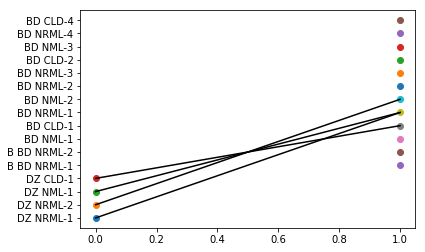

In [172]:
for i in dz:
    plt.plot(0, i, "o")
for j in break_down_zones:
    plt.plot(1, j, "o")
for i in dz:
    for j in break_down_zones:
        if(x[i,j].x>0.5):
            plt.plot([0,1], [i,j], "k")# todo
            
plt.show()

In [173]:
booking.columns

Index(['Shipment ID', 'FlightDate', 'ShipmentArrivalDateUTC', 'ProductName',
       'ShipmentOrigin', 'ShipmentDestination', 'CarrierCode', 'Priority',
       'DropZone', 'FlightNumberArrival', 'SerialNumber', 'ArrivalULDNumber',
       'Pieces', 'Weight', 'Volume', 'BookingStatus', 'WeighCMMit',
       'VolumeUnit', 'TotalVolume', 'TotalWeight', 'TotalNumberOfPieces',
       'FlightNumberDeparture', 'ShipmentDepartureDateUTC'],
      dtype='object')

In [174]:
booking['ShipmentArrivalDateUTC'].dtype

dtype('O')

In [175]:
booking['Shipment_arrival_date_time'] = pd.to_datetime(booking['ShipmentArrivalDateUTC'])

In [176]:
booking.head()

,Shipment ID,FlightDate,ShipmentArrivalDateUTC,ProductName,ShipmentOrigin,ShipmentDestination,CarrierCode,Priority,DropZone,FlightNumberArrival,...,Volume,BookingStatus,WeighCMMit,VolumeUnit,TotalVolume,TotalWeight,TotalNumberOfPieces,FlightNumberDeparture,ShipmentDepartureDateUTC,Shipment_arrival_date_time
0,020-77215633,2018-10-23,2018-10-23T06:10:00,NRML,BBB,ACC,ZZ,False,DZ NRML-2,1,...,0.08,C,K,B,0.08,26.2,1,3,2018-10-25T05:15:00,2018-10-23 06:10:00
1,020-77215515,2018-10-23,2018-10-23T06:10:00,NRML,BBB,ADD,ZZ,False,DZ NRML-2,1,...,0.02,C,K,B,0.02,5.5,1,4,2018-10-27T13:45:00,2018-10-23 06:10:00
2,020-84100306,2018-10-23,2018-10-23T06:10:00,NML,BBB,AGG,ZZ,False,DZ NML-1,1,...,0.01,C,K,B,0.01,2.6,1,7,2018-10-24T21:20:00,2018-10-23 06:10:00
3,020-82036091,2018-10-23,2018-10-23T06:10:00,NRML,BBB,AII,ZZ,False,DZ NRML-2,1,...,0.01,C,K,B,0.01,1.7,1,9,2018-10-27T17:20:00,2018-10-23 06:10:00
4,020-84368815,2018-10-23,2018-10-23T06:10:00,NRML,BBB,CCC,ZZ,False,DZ NRML-2,1,...,0.26,C,K,B,0.26,22.6,1,46,2018-10-24T23:00:00,2018-10-23 06:10:00


In [177]:
pd.to_datetime(booking['ShipmentArrivalDateUTC'])

0     2018-10-23 06:10:00
1     2018-10-23 06:10:00
2     2018-10-23 06:10:00
3     2018-10-23 06:10:00
4     2018-10-23 06:10:00
5     2018-10-23 06:10:00
6     2018-10-23 06:10:00
7     2018-10-23 06:10:00
8     2018-10-23 06:10:00
9     2018-10-23 06:10:00
10    2018-10-23 06:10:00
11    2018-10-23 06:10:00
12    2018-10-23 06:10:00
13    2018-10-23 06:10:00
14    2018-10-23 06:10:00
15    2018-10-23 06:10:00
16    2018-10-23 06:10:00
17    2018-10-23 06:10:00
18    2018-10-23 06:10:00
19    2018-10-23 06:10:00
20    2018-10-23 06:10:00
21    2018-10-23 06:10:00
22    2018-10-23 06:10:00
23    2018-10-23 06:10:00
24    2018-10-23 06:10:00
25    2018-10-23 06:10:00
26    2018-10-23 06:10:00
27    2018-10-23 06:10:00
28    2018-10-23 06:10:00
29    2018-10-23 06:10:00
              ...        
755   2018-10-27 01:45:00
756   2018-10-27 01:45:00
757   2018-10-27 01:45:00
758   2018-10-27 01:45:00
759   2018-10-25 01:45:00
760   2018-10-25 01:45:00
761   2018-10-24 04:30:00
762   2018-1

In [178]:
booking['ShipmentDepartureDateUTC'].dtype

dtype('O')

In [179]:
#booking['ShipmentDepartureDateUTC'].str.replace('T',' ')

In [180]:
booking['ShipmentDepartureDateUTC'].unique()

array(['2018-10-25T05:15:00', '2018-10-27T13:45:00',
       '2018-10-24T21:20:00', '2018-10-27T17:20:00',
       '2018-10-24T23:00:00', '2018-10-26T06:45:00',
       '2018-10-25T13:30:00', '2018-10-24T23:30:00',
       '2018-10-26T19:10:00', '2018-10-27T08:30:00',
       '2018-10-25T18:20:00', '2018-10-27T14:50:00',
       '2018-10-24T19:05:00', '2018-10-25T14:05:00',
       '2018-10-26T18:55:00', '2018-10-25T22:30:00',
       '2018-10-25T02:00:00', '2018-10-25T16:35:00',
       '2018-10-25T23:15:00', '2018-10-23T19:10:00',
       '2018-10-24T20:10:00', '2018-10-24T20:25:00',
       '2018-10-26T01:30:00', '2018-10-26T14:20:00',
       '2018-10-25T13:45:00', '2018-10-24T05:00:00',
       '2018-10-25T02:50:00', '2018-10-25T02:20:00',
       '2018-10-25T05:00:00', '2018-10-26T10:45:00',
       '2018-10-25T11:10:00', '2018-10-25T21:20:00',
       '2018-10-25T11:30:00', '2018-10-25T06:00:00',
       '2018-10-30T05:00:00', '2018-10-24T18:45:00',
       '2018-10-25T20:55:00', '2018-10-25T06:3

In [181]:
booking = booking[booking.ShipmentDepartureDateUTC != '2018-10-24T26:20:00']

In [182]:
booking['Shipment_departure_date_time'] = pd.to_datetime(booking['ShipmentDepartureDateUTC'])

In [183]:
booking['Shipment_duration'] = booking['Shipment_departure_date_time']-booking['Shipment_arrival_date_time']

In [184]:
booking.head()

,Shipment ID,FlightDate,ShipmentArrivalDateUTC,ProductName,ShipmentOrigin,ShipmentDestination,CarrierCode,Priority,DropZone,FlightNumberArrival,...,WeighCMMit,VolumeUnit,TotalVolume,TotalWeight,TotalNumberOfPieces,FlightNumberDeparture,ShipmentDepartureDateUTC,Shipment_arrival_date_time,Shipment_departure_date_time,Shipment_duration
0,020-77215633,2018-10-23,2018-10-23T06:10:00,NRML,BBB,ACC,ZZ,False,DZ NRML-2,1,...,K,B,0.08,26.2,1,3,2018-10-25T05:15:00,2018-10-23 06:10:00,2018-10-25 05:15:00,1 days 23:05:00
1,020-77215515,2018-10-23,2018-10-23T06:10:00,NRML,BBB,ADD,ZZ,False,DZ NRML-2,1,...,K,B,0.02,5.5,1,4,2018-10-27T13:45:00,2018-10-23 06:10:00,2018-10-27 13:45:00,4 days 07:35:00
2,020-84100306,2018-10-23,2018-10-23T06:10:00,NML,BBB,AGG,ZZ,False,DZ NML-1,1,...,K,B,0.01,2.6,1,7,2018-10-24T21:20:00,2018-10-23 06:10:00,2018-10-24 21:20:00,1 days 15:10:00
3,020-82036091,2018-10-23,2018-10-23T06:10:00,NRML,BBB,AII,ZZ,False,DZ NRML-2,1,...,K,B,0.01,1.7,1,9,2018-10-27T17:20:00,2018-10-23 06:10:00,2018-10-27 17:20:00,4 days 11:10:00
4,020-84368815,2018-10-23,2018-10-23T06:10:00,NRML,BBB,CCC,ZZ,False,DZ NRML-2,1,...,K,B,0.26,22.6,1,46,2018-10-24T23:00:00,2018-10-23 06:10:00,2018-10-24 23:00:00,1 days 16:50:00


In [185]:
booking[booking.Shipment_duration<pd.Timedelta(0)]

,Shipment ID,FlightDate,ShipmentArrivalDateUTC,ProductName,ShipmentOrigin,ShipmentDestination,CarrierCode,Priority,DropZone,FlightNumberArrival,...,WeighCMMit,VolumeUnit,TotalVolume,TotalWeight,TotalNumberOfPieces,FlightNumberDeparture,ShipmentDepartureDateUTC,Shipment_arrival_date_time,Shipment_departure_date_time,Shipment_duration
53,020-88442185,2018-10-25,2018-10-25T06:35:00,NRML,OOO,BBB,ZZ,False,DZ NRML-1,2,...,K,B,0.32,23.5,3,25,2018-10-25T02:20:00,2018-10-25 06:35:00,2018-10-25 02:20:00,-1 days +19:45:00
54,020-88442196,2018-10-25,2018-10-25T06:35:00,NRML,OOO,BBB,ZZ,False,DZ NRML-1,2,...,K,B,0.44,43.7,4,25,2018-10-25T02:20:00,2018-10-25 06:35:00,2018-10-25 02:20:00,-1 days +19:45:00
55,020-88442200,2018-10-25,2018-10-25T06:35:00,NRML,OOO,BBB,ZZ,False,DZ NRML-1,2,...,K,B,0.12,9.6,2,25,2018-10-25T02:20:00,2018-10-25 06:35:00,2018-10-25 02:20:00,-1 days +19:45:00
56,020-86837940,2018-10-25,2018-10-25T06:35:00,NML,OOO,BBB,ZZ,False,DZ NML-1,2,...,K,B,0.60,39.5,18,25,2018-10-25T02:20:00,2018-10-25 06:35:00,2018-10-25 02:20:00,-1 days +19:45:00
59,020-83907692,2018-10-25,2018-10-25T11:05:00,NRML,OOO,BBB,ZZ,False,DZ NRML-1,12,...,K,B,0.20,9.5,2,25,2018-10-25T02:20:00,2018-10-25 11:05:00,2018-10-25 02:20:00,-1 days +15:15:00
426,020-84475440,2018-10-25,2018-10-25T13:10:00,NML,AUU,ABB,ZZ,False,DZ NML-1,438,...,K,B,1.62,84.1,12,2,2018-10-25T02:50:00,2018-10-25 13:10:00,2018-10-25 02:50:00,-1 days +13:40:00


In [186]:
len(booking['ArrivalULDNumber'].unique())

309

In [187]:
dz_ship_data = booking[['DropZone','ArrivalULDNumber']]

In [188]:
dz_to_bd.head()

,BreakDownZoneName,DropZoneName,TransportDuration,h,m,s
0,B BD NRML-1,DZ NRML-1,00:25:00,0,25,0
1,B BD NRML-2,DZ NRML-1,00:11:00,0,11,0
2,BD NML-1,DZ NRML-1,00:19:00,0,19,0
3,BD CLD-1,DZ NRML-1,00:24:00,0,24,0
4,BD NRML-1,DZ NRML-1,00:05:00,0,5,0


In [189]:
uld_bd_data = pd.merge(dz_ship_data, dz_to_bd, left_on='DropZone', right_on='DropZoneName')

In [190]:
uld_bd_data['key'] = uld_bd_data['ArrivalULDNumber'].astype(str) + '_' + uld_bd_data['BreakDownZoneName']

In [191]:
#uld_bd_data = uld_bd_data.drop_duplicates('key')

In [192]:
uld_bd_data

,DropZone,ArrivalULDNumber,BreakDownZoneName,DropZoneName,TransportDuration,h,m,s,key
0,DZ NRML-2,21231,B BD NRML-1,DZ NRML-2,00:11:00,0,11,0,21231_B BD NRML-1
1,DZ NRML-2,21231,B BD NRML-2,DZ NRML-2,00:17:00,0,17,0,21231_B BD NRML-2
2,DZ NRML-2,21231,BD NML-1,DZ NRML-2,00:12:00,0,12,0,21231_BD NML-1
3,DZ NRML-2,21231,BD CLD-1,DZ NRML-2,00:16:00,0,16,0,21231_BD CLD-1
4,DZ NRML-2,21231,BD NRML-1,DZ NRML-2,00:05:00,0,5,0,21231_BD NRML-1
5,DZ NRML-2,21231,BD NML-2,DZ NRML-2,00:03:00,0,3,0,21231_BD NML-2
6,DZ NRML-2,21231,BD NRML-2,DZ NRML-2,00:24:00,0,24,0,21231_BD NRML-2
7,DZ NRML-2,21231,BD NRML-3,DZ NRML-2,00:06:00,0,6,0,21231_BD NRML-3
8,DZ NRML-2,21231,BD CLD-2,DZ NRML-2,00:07:00,0,7,0,21231_BD CLD-2
9,DZ NRML-2,21231,BD NML-3,DZ NRML-2,00:15:00,0,15,0,21231_BD NML-3


In [193]:
uld_bd_data['dz_type'] =  uld_bd_data['DropZone'].apply(lambda x: x.split('-')[0]).str[3:]

In [194]:
uld_bd_data['bd_type1'] = uld_bd_data['BreakDownZoneName'].apply(lambda x: x.split(' ')[1])

In [195]:
uld_bd_data.loc[uld_bd_data['bd_type1'] == 'BD', 'bd_type1'] = "NRML-1"

In [196]:
uld_bd_data['bd_type'] =  uld_bd_data['bd_type1'].apply(lambda x: x.split('-')[0])

In [197]:
uld_bd_data['key_for_type'] = uld_bd_data.apply(lambda x: '1' if x['dz_type'] == x['bd_type'] else '0', axis=1)

In [198]:
uld_bd_data = uld_bd_data[(uld_bd_data.key_for_type == '1') & (uld_bd_data.dz_type == 'NRML')]
uld_bd_data = uld_bd_data.drop_duplicates('key')
uld_bd_data.shape

(1734, 13)

In [199]:
break_down_zones = list(uld_bd_data['BreakDownZoneName'].unique())

In [200]:
break_down_zones

['B BD NRML-1',
 'B BD NRML-2',
 'BD NRML-1',
 'BD NRML-2',
 'BD NRML-3',
 'BD NRML-4']

In [201]:
uld_bd_data['BreakDownZoneName'].unique()

array(['B BD NRML-1', 'B BD NRML-2', 'BD NRML-1', 'BD NRML-2',
       'BD NRML-3', 'BD NRML-4'], dtype=object)

In [202]:
ulds_number = list(uld_bd_data['ArrivalULDNumber'].unique())

In [203]:
len(uld_bd_data['ArrivalULDNumber'].unique())

289

In [204]:
uld_to_bd_times = tupledict(pd.Series(uld_bd_data.m.values,index=[uld_bd_data.ArrivalULDNumber, uld_bd_data.BreakDownZoneName]).to_dict())

In [205]:
model = Model('BD zone model')

In [206]:
x = {}
for i in ulds_number:
    for j in break_down_zones:
        x[i,j] = model.addVar(obj=uld_to_bd_times[i,j], vtype=GRB.BINARY)
        #print(time_to_dz_bd[i,j])

In [207]:
for j in break_down_zones:
    model.addConstr(quicksum(x[i,j] for i in ulds_number) <= 5000)

In [208]:
for i in ulds_number:
    model.addConstr(quicksum(x[i,j] for j in break_down_zones) == 1)

In [209]:
model.optimize()

Optimize a model with 295 rows, 1734 columns and 3468 nonzeros
Variable types: 0 continuous, 1734 integer (1734 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e+00, 2e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+03]
Found heuristic solution: objective 4506.0000000
Presolve removed 295 rows and 1734 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.02 seconds
Thread count was 1 (of 4 available processors)

Solution count 2: 1445 4506 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.445000000000e+03, best bound 1.445000000000e+03, gap 0.0000%


In [210]:
# output solution
for i in ulds_number:
    for j in break_down_zones:
        if(x[i,j].x>0.5):
            print(i, "assigned to", j)# todo

21231 assigned to BD NRML-1
24321 assigned to BD NRML-1
42309 assigned to BD NRML-1
49809 assigned to BD NRML-1
44509 assigned to BD NRML-1
34521 assigned to BD NRML-1
34576 assigned to BD NRML-1
34849 assigned to BD NRML-1
53111 assigned to BD NRML-1
53252 assigned to BD NRML-1
92841 assigned to BD NRML-1
92852 assigned to BD NRML-1
92854 assigned to BD NRML-1
92862 assigned to BD NRML-1
92863 assigned to BD NRML-1
92874 assigned to BD NRML-1
55210 assigned to BD NRML-1
55233 assigned to BD NRML-1
34441 assigned to BD NRML-1
55234 assigned to BD NRML-1
55244 assigned to BD NRML-1
55242 assigned to BD NRML-1
55256 assigned to BD NRML-1
43343 assigned to BD NRML-1
12199 assigned to BD NRML-1
55267 assigned to BD NRML-1
51207 assigned to BD NRML-1
51217 assigned to BD NRML-1
51216 assigned to BD NRML-1
51219 assigned to BD NRML-1
51227 assigned to BD NRML-1
51228 assigned to BD NRML-1
51229 assigned to BD NRML-1
51230 assigned to BD NRML-1
59235 assigned to BD NRML-1
59246 assigned to BD

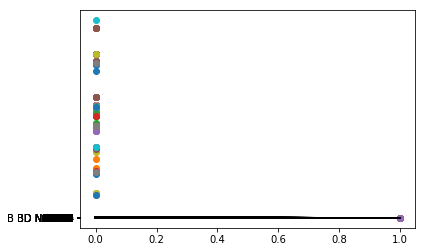

In [211]:
for i in ulds_number:
    plt.plot(0, i, "o")
for j in break_down_zones:
    plt.plot(1, j, "o")
    
for i in ulds_number:
    for j in break_down_zones:
        if(x[i,j].x>0.5):
            plt.plot([0,1], [i,j], "k")# todo
            
plt.show()

In [212]:
import numpy as np

In [213]:
booking['ULD_time_spend'] = "2"

In [214]:
booking['build_up_arrival_time'] =  booking['Shipment_arrival_date_time'] + np.timedelta64(2, 'h')
booking['build_up_finish_time'] =  booking['Shipment_departure_date_time'] - np.timedelta64(1, 'h')

In [215]:
booking.groupby(['build_up_arrival_time', 'ProductName'])[['ArrivalULDNumber']].count().reset_index()

,build_up_arrival_time,ProductName,ArrivalULDNumber
0,2018-10-16 17:25:00,NRML,1
1,2018-10-17 08:00:00,NRML,1
2,2018-10-22 17:10:00,NRML,1
3,2018-10-23 01:00:00,NML,1
4,2018-10-23 06:35:00,NRML,1
5,2018-10-23 07:30:00,NRML,1
6,2018-10-23 08:00:00,NRML,9
7,2018-10-23 08:10:00,NML,3
8,2018-10-23 08:10:00,NRML,50
9,2018-10-23 08:35:00,NRML,1


In [216]:
shipment_arrival_type = booking.groupby(['build_up_arrival_time', 'ProductName'])[['ArrivalULDNumber']].count().reset_index()
shipment_arrival_type = shipment_arrival_type.drop_duplicates('ArrivalULDNumber')
shipment_arrival_type['ArrivalULDNumber'].max()

50

In [217]:
test = shipment_arrival_type.groupby(['build_up_arrival_time', 'ProductName'])[['ArrivalULDNumber']].count().reset_index()
test = test[test.ProductName == 'NRML']

In [218]:
test[test.ArrivalULDNumber > 3]

,build_up_arrival_time,ProductName,ArrivalULDNumber


In [219]:
shipment_arrival_type

,build_up_arrival_time,ProductName,ArrivalULDNumber
0,2018-10-16 17:25:00,NRML,1
6,2018-10-23 08:00:00,NRML,9
7,2018-10-23 08:10:00,NML,3
8,2018-10-23 08:10:00,NRML,50
10,2018-10-23 08:55:00,NRML,10
15,2018-10-23 09:25:00,NML,2
21,2018-10-23 10:00:00,NRML,5
28,2018-10-23 11:50:00,NRML,6
35,2018-10-23 13:10:00,NRML,12
40,2018-10-23 14:50:00,NRML,4


In [220]:
rnm_cols = dict(count='Count')
booking.set_index(['build_up_arrival_time', 'ProductName', 'ArrivalULDNumber']).stack().groupby(['build_up_arrival_time', 'ProductName', 'ArrivalULDNumber']).agg(rnm_cols.keys()).rename(columns=rnm_cols)

Count
build_up_arrival_time ProductName ArrivalULDNumber       
2018-10-16 17:25:00   NRML        71900                26
2018-10-17 08:00:00   NRML        52212                26
2018-10-22 17:10:00   NRML        51207                26
2018-10-23 01:00:00   NML         55237                26
2018-10-23 06:35:00   NRML        49818                26
2018-10-23 07:30:00   NRML        80271                26
2018-10-23 08:00:00   NRML        42424                52
                                  55260                52
                                  92870               130
2018-10-23 08:10:00   NML         21231                52
                                  23127                26
                      NRML        21231               546
                                  23127               312
                                  24321               442
2018-10-23 08:35:00   NRML        49828                26
2018-10-23 08:55:00   NRML        59248               260
2018-10-23 09:00:00   NML         59271                26
                      NRML        59271                26
2018-10-23 09:15:00   NRML        80183                26
2018-10-23 09:20:00   NRML        49808                52
                                  80308                26
2018-10-23 09:25:00   NML         92852                52
                      NRML        92852                52
2018-10-23 09:30:00   NRML        59259                26
2018-10-23 09:40:00   NRML        80161                26
2018-10-23 09:55:00   NRML        80156                26
2018-10-23 10:00:00   NML         51228                26
                      NRML        51228                78
                                  92871                52
2018-10-23 10:05:00   NRML        80132                52
...                                                   ...
2018-10-25 15:00:00   NRML        59264                52
2018-10-25 15:10:00   NML         44914                26
2018-10-25 15:20:00   NRML        53111                26
2018-10-25 15:55:00   NRML        22422                26
                                  51214                26
                                  80199                52
2018-10-25 16:00:00   NRML        44909                26
2018-10-25 17:15:00   NRML        49835                26
2018-10-25 17:20:00   NRML        55242                26
2018-10-25 19:40:00   NRML        44935                78
2018-10-25 20:30:00   NRML        80221                26
2018-10-26 00:40:00   NRML        51227                26
2018-10-26 01:00:00   NRML        49813                26
2018-10-26 02:30:00   NRML        80117                26
2018-10-26 03:30:00   NRML        80268                26
2018-10-26 04:00:00   NRML        80265                26
2018-10-26 07:35:00   NRML        51204                26
2018-10-26 10:00:00   NRML        80222                26
2018-10-26 11:00:00   NRML        80277                26
2018-10-26 12:00:00   NRML        80280                26
2018-10-26 16:50:00   NRML        80185                26
2018-10-26 20:20:00   NRML        55258                26
2018-10-26 20:30:00   NRML        80221                26
                                  80234                26
2018-10-27 03:45:00   NRML        80255               130
2018-10-27 06:50:00   NRML        80249                26
2018-10-28 19:25:00   NRML        55263                26
2018-10-29 07:00:00   NRML        80283                26
2018-10-29 14:15:00   NRML        80114                26
2018-10-29 16:25:00   NRML        92852                26

[382 rows x 1 columns]

In [221]:
###############################################################################################################

In [222]:
booking_new = booking[['ProductName', 'Priority', 'DropZone', 'ArrivalULDNumber', 'Pieces', 'Weight', 'TotalWeight',
         'FlightNumberDeparture', 'Shipment_arrival_date_time', 'Shipment_departure_date_time',
         'Shipment_duration', 'build_up_arrival_time', 'build_up_finish_time']]

In [223]:
booking_new = pd.merge(booking_new, bu_zones_to_flight, left_on='FlightNumberDeparture', right_on='FlightNumber')

In [224]:
booking_new = pd.merge(booking_new, bu_zones, left_on='BU Zone', right_on='Name')

In [225]:
booking_new.columns

Index(['ProductName', 'Priority', 'DropZone', 'ArrivalULDNumber', 'Pieces',
       'Weight', 'TotalWeight', 'FlightNumberDeparture',
       'Shipment_arrival_date_time', 'Shipment_departure_date_time',
       'Shipment_duration', 'build_up_arrival_time', 'build_up_finish_time',
       'FlightNumber', 'BU Zone', 'TransportationDistance', 'Name',
       'HandlingTimePerULD', 'TransportationTimeToWH'],
      dtype='object')

In [226]:
bu_workstation_count = bu_zones_workstations.groupby(['Name']).count().reset_index()
bu_workstation_count.columns = ['Name', 'Count']

In [227]:
bd_zone_all = pd.merge(bu_zones, bu_workstation_count, left_on='Name', right_on='Name')

In [228]:
bd_zone_all

,Name,HandlingTimePerULD,TransportationTimeToWH,Count
0,BU FT-1,00:24:00,00:50:00,5
1,BU FT-2,00:24:00,00:45:00,6
2,BU NML-1,00:13:00,00:40:00,4
3,BU CBD-1,00:17:00,00:50:00,7
4,BU NRML-1,00:20:00,00:50:00,3
5,BU NML-2,00:13:00,00:45:00,3
6,BU NRML-2,00:20:00,00:40:00,5
7,BU NRML-3,00:20:00,00:40:00,3


In [229]:
bd_zone_all = pd.merge(bd_zone_all, bu_zones_to_flight, left_on='Name', right_on='BU Zone')

In [230]:
booking_new = pd.merge(booking_new, bd_zone_all, left_on='FlightNumberDeparture', right_on='FlightNumber')

In [231]:
booking_new

,ProductName,Priority,DropZone,ArrivalULDNumber,Pieces,Weight,TotalWeight,FlightNumberDeparture,Shipment_arrival_date_time,Shipment_departure_date_time,...,Name_x,HandlingTimePerULD_x,TransportationTimeToWH_x,Name_y,HandlingTimePerULD_y,TransportationTimeToWH_y,Count,FlightNumber_y,BU Zone_y,TransportationDistance_y
0,NRML,False,DZ NRML-2,21231,1,26.2,26.2,3,2018-10-23 06:10:00,2018-10-25 05:15:00,...,BU FT-1,00:24:00,00:50:00,BU FT-1,00:24:00,00:50:00,5,3,BU FT-1,00:19:00
1,NRML,False,DZ NRML-1,76631,1,6.5,6.5,3,2018-10-23 20:10:00,2018-10-25 05:15:00,...,BU FT-1,00:24:00,00:50:00,BU FT-1,00:24:00,00:50:00,5,3,BU FT-1,00:19:00
2,NRML,False,DZ NRML-1,59245,1,10.5,10.5,3,2018-10-23 19:05:00,2018-10-25 05:15:00,...,BU FT-1,00:24:00,00:50:00,BU FT-1,00:24:00,00:50:00,5,3,BU FT-1,00:19:00
3,NRML,False,DZ NRML-1,44942,1,10.5,10.5,3,2018-10-24 15:40:00,2018-10-25 05:15:00,...,BU FT-1,00:24:00,00:50:00,BU FT-1,00:24:00,00:50:00,5,3,BU FT-1,00:19:00
4,NRML,False,DZ NRML-1,44942,1,6.5,6.5,3,2018-10-24 15:40:00,2018-10-25 05:15:00,...,BU FT-1,00:24:00,00:50:00,BU FT-1,00:24:00,00:50:00,5,3,BU FT-1,00:19:00
5,NRML,False,DZ NRML-1,44942,1,26.2,26.2,3,2018-10-24 15:40:00,2018-10-25 05:15:00,...,BU FT-1,00:24:00,00:50:00,BU FT-1,00:24:00,00:50:00,5,3,BU FT-1,00:19:00
6,NRML,False,DZ NRML-2,21231,1,5.5,5.5,4,2018-10-23 06:10:00,2018-10-27 13:45:00,...,BU FT-1,00:24:00,00:50:00,BU FT-1,00:24:00,00:50:00,5,4,BU FT-1,00:24:00
7,NRML,False,DZ NRML-1,53409,1,0.8,0.8,4,2018-10-23 18:10:00,2018-10-27 13:45:00,...,BU FT-1,00:24:00,00:50:00,BU FT-1,00:24:00,00:50:00,5,4,BU FT-1,00:24:00
8,NRML,False,DZ NRML-2,92852,1,31.8,31.8,4,2018-10-23 07:25:00,2018-10-27 13:45:00,...,BU FT-1,00:24:00,00:50:00,BU FT-1,00:24:00,00:50:00,5,4,BU FT-1,00:24:00
9,NRML,False,DZ NRML-1,51200,4,242.4,242.4,4,2018-10-23 12:55:00,2018-10-27 13:45:00,...,BU FT-1,00:24:00,00:50:00,BU FT-1,00:24:00,00:50:00,5,4,BU FT-1,00:24:00


In [232]:
#dem_k variable - total shipment available for flight K
dem = booking.groupby(['FlightNumberDeparture'])['Weight'].sum().reset_index()
dem_k = pd.Series(dem.Weight.values, index=dem.FlightNumberDeparture).to_dict()

In [233]:
due_k = pd.Series(booking.build_up_finish_time.values, index=booking.FlightNumberDeparture).to_dict()

In [234]:
dem['ULD_count_decimal'] = dem['Weight']/400.0

In [235]:
dem['ULD_count'] = np.ceil(dem['ULD_count_decimal'])

In [236]:
uld_k = pd.Series(dem.ULD_count.astype(int).values, index=dem.FlightNumberDeparture).to_dict()

In [237]:
booking_new[['ULD_handling_h','ULD_handling_m','ULD_handling_s']] = pd.DataFrame([(x.hour, x.minute, x.second) for x in booking_new['HandlingTimePerULD_x']])

In [238]:
dur_k = pd.Series(booking_new.ULD_handling_m.values, index=booking_new.FlightNumberDeparture).to_dict()

In [239]:
dur_k

{3: 24,
 4: 24,
 1: 24,
 2: 24,
 5: 24,
 6: 24,
 7: 24,
 9: 24,
 8: 24,
 13: 24,
 10: 24,
 11: 24,
 12: 24,
 14: 24,
 46: 20,
 43: 20,
 42: 20,
 40: 20,
 44: 20,
 45: 20,
 48: 20,
 47: 20,
 41: 20,
 49: 20,
 50: 20,
 60: 20,
 61: 20,
 62: 20,
 63: 20,
 64: 20,
 65: 20,
 66: 20,
 67: 20,
 68: 20,
 69: 20,
 70: 20,
 59: 20,
 71: 17,
 72: 17,
 73: 17,
 74: 17,
 75: 17,
 76: 17,
 77: 17,
 78: 17,
 79: 17,
 82: 17,
 81: 17,
 80: 17,
 25: 13,
 15: 13,
 16: 13,
 18: 13,
 21: 13,
 22: 13,
 26: 13,
 28: 13,
 27: 13,
 23: 13,
 17: 13,
 19: 13,
 20: 13,
 24: 13,
 29: 13,
 34: 13,
 31: 13,
 32: 13,
 36: 13,
 33: 13,
 35: 13,
 30: 13,
 38: 13,
 37: 13,
 39: 13,
 54: 20,
 57: 20,
 55: 20,
 52: 20,
 56: 20,
 58: 20,
 53: 20,
 51: 20}

In [240]:
booking_new.columns

Index(['ProductName', 'Priority', 'DropZone', 'ArrivalULDNumber', 'Pieces',
       'Weight', 'TotalWeight', 'FlightNumberDeparture',
       'Shipment_arrival_date_time', 'Shipment_departure_date_time',
       'Shipment_duration', 'build_up_arrival_time', 'build_up_finish_time',
       'FlightNumber_x', 'BU Zone_x', 'TransportationDistance_x', 'Name_x',
       'HandlingTimePerULD_x', 'TransportationTimeToWH_x', 'Name_y',
       'HandlingTimePerULD_y', 'TransportationTimeToWH_y', 'Count',
       'FlightNumber_y', 'BU Zone_y', 'TransportationDistance_y',
       'ULD_handling_h', 'ULD_handling_m', 'ULD_handling_s'],
      dtype='object')

In [241]:
booking_new['arrival_date'] = booking_new['Shipment_arrival_date_time'].dt.normalize()
booking_new['departure_date'] = booking_new['Shipment_departure_date_time'].dt.normalize()

In [242]:
booking_new['departure_date'].value_counts()

2018-10-25    323
2018-10-24    185
2018-10-26     82
2018-10-30     59
2018-10-27     43
2018-10-29     13
2018-10-23      4
Name: departure_date, dtype: int64

In [243]:
##############################################################
#Only One Date

SyntaxError: invalid syntax (<ipython-input-243-3867e5c85618>, line 2)

In [244]:
booking_only_one = booking_new[booking_new.departure_date == '2018-10-23']

In [245]:
booking_only_one

,ProductName,Priority,DropZone,ArrivalULDNumber,Pieces,Weight,TotalWeight,FlightNumberDeparture,Shipment_arrival_date_time,Shipment_departure_date_time,...,TransportationTimeToWH_y,Count,FlightNumber_y,BU Zone_y,TransportationDistance_y,ULD_handling_h,ULD_handling_m,ULD_handling_s,arrival_date,departure_date
483,NML,False,DZ NML-1,23127,1,5.1,5.1,74,2018-10-23 06:10:00,2018-10-23 19:10:00,...,00:50:00,7,74,BU CBD-1,00:14:00,0,17,0,2018-10-23,2018-10-23
484,NML,False,DZ NML-1,55237,1,5.1,5.1,74,2018-10-22 23:00:00,2018-10-23 19:10:00,...,00:50:00,7,74,BU CBD-1,00:14:00,0,17,0,2018-10-22,2018-10-23
687,NML,False,DZ NML-1,59271,2,23.5,24.3,39,2018-10-23 07:00:00,2018-10-23 21:05:00,...,00:45:00,3,39,BU NML-2,00:24:00,0,13,0,2018-10-23,2018-10-23
688,NML,False,DZ NML-1,59286,2,24.5,24.3,39,2018-10-23 14:45:00,2018-10-23 21:05:00,...,00:45:00,3,39,BU NML-2,00:24:00,0,13,0,2018-10-23,2018-10-23


In [246]:
booking_only_one['Shipment_arrival_date_time'].value_counts()

2018-10-23 07:00:00    1
2018-10-22 23:00:00    1
2018-10-23 06:10:00    1
2018-10-23 14:45:00    1
Name: Shipment_arrival_date_time, dtype: int64

In [247]:
booking_new.columns

Index(['ProductName', 'Priority', 'DropZone', 'ArrivalULDNumber', 'Pieces',
       'Weight', 'TotalWeight', 'FlightNumberDeparture',
       'Shipment_arrival_date_time', 'Shipment_departure_date_time',
       'Shipment_duration', 'build_up_arrival_time', 'build_up_finish_time',
       'FlightNumber_x', 'BU Zone_x', 'TransportationDistance_x', 'Name_x',
       'HandlingTimePerULD_x', 'TransportationTimeToWH_x', 'Name_y',
       'HandlingTimePerULD_y', 'TransportationTimeToWH_y', 'Count',
       'FlightNumber_y', 'BU Zone_y', 'TransportationDistance_y',
       'ULD_handling_h', 'ULD_handling_m', 'ULD_handling_s', 'arrival_date',
       'departure_date'],
      dtype='object')

In [248]:
sample_shipments = booking_new.iloc[0:100,:]

In [249]:
sample_shipments['Shipment_duration_minutes'] = (sample_shipments['Shipment_duration'] / np.timedelta64(1, 'm')).astype(int)

/home/luckshan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [250]:
sample_shipments['Shipment_arrival_time_minutes'] = pd.to_timedelta(sample_shipments['Shipment_arrival_date_time']).astype('timedelta64[m]').astype(int)

/home/luckshan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Passing datetime64-dtype data to TimedeltaIndex is deprecated, will raise a TypeError in a future version
  """Entry point for launching an IPython kernel.
/home/luckshan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [251]:
sample_shipments.head()

,ProductName,Priority,DropZone,ArrivalULDNumber,Pieces,Weight,TotalWeight,FlightNumberDeparture,Shipment_arrival_date_time,Shipment_departure_date_time,...,FlightNumber_y,BU Zone_y,TransportationDistance_y,ULD_handling_h,ULD_handling_m,ULD_handling_s,arrival_date,departure_date,Shipment_duration_minutes,Shipment_arrival_time_minutes
0,NRML,False,DZ NRML-2,21231,1,26.2,26.2,3,2018-10-23 06:10:00,2018-10-25 05:15:00,...,3,BU FT-1,00:19:00,0,24,0,2018-10-23,2018-10-25,2825,25671250
1,NRML,False,DZ NRML-1,76631,1,6.5,6.5,3,2018-10-23 20:10:00,2018-10-25 05:15:00,...,3,BU FT-1,00:19:00,0,24,0,2018-10-23,2018-10-25,1985,25672090
2,NRML,False,DZ NRML-1,59245,1,10.5,10.5,3,2018-10-23 19:05:00,2018-10-25 05:15:00,...,3,BU FT-1,00:19:00,0,24,0,2018-10-23,2018-10-25,2050,25672025
3,NRML,False,DZ NRML-1,44942,1,10.5,10.5,3,2018-10-24 15:40:00,2018-10-25 05:15:00,...,3,BU FT-1,00:19:00,0,24,0,2018-10-24,2018-10-25,815,25673260
4,NRML,False,DZ NRML-1,44942,1,6.5,6.5,3,2018-10-24 15:40:00,2018-10-25 05:15:00,...,3,BU FT-1,00:19:00,0,24,0,2018-10-24,2018-10-25,815,25673260


In [252]:
Shipment_duration_minutes_list = list(sample_shipments['Shipment_duration_minutes'].unique())
Shipment_arrival_time_minutes_list = list(sample_shipments['Shipment_arrival_time_minutes'].unique())

In [ ]:
Shipment_duration_minutes_list

In [ ]:
a=[]
#for i in Shipment_arrival_time_minutes_list:
for j in Shipment_duration_minutes_list:
    print(j)
    #for k in range(j):
        #print(k)

In [ ]:
x = {}
for i in ulds_number:
    for j in break_down_zones:
        for t in Shipment_duration_minutes:
            print
        #x[i,j] = model.addVar(obj=uld_to_bd_times[i,j], vtype=GRB.BINARY)

In [ ]:
columnSeriesObj = sample_shipments['Shipment_duration_minutes']
#print(columnSeriesObj)
for j in columnSeriesObj:
    print(j)
    ld_to_bd_times = tupledict(pd.Series(uld_bd_data.m.values,index=[uld_bd_data.ArrivalULDNumber, uld_bd_data.BreakDownZoneName, ]).to_dict())

In [ ]:
ld_to_bd_times = tupledict(pd.Series(uld_bd_data.m.values,index=[uld_bd_data.ArrivalULDNumber, uld_bd_data.BreakDownZoneName]).to_dict())

In [253]:
new = sample_shipments[['ArrivalULDNumber', 'Shipment_duration_minutes','Shipment_arrival_time_minutes']]

In [254]:
df_merge= pd.merge(uld_bd_data, new, on='ArrivalULDNumber')

In [255]:
df_merge = df_merge.drop_duplicates('key')

In [256]:
df_merge.head()

,DropZone,ArrivalULDNumber,BreakDownZoneName,DropZoneName,TransportDuration,h,m,s,key,dz_type,bd_type1,bd_type,key_for_type,Shipment_duration_minutes,Shipment_arrival_time_minutes
0,DZ NRML-2,21231,B BD NRML-1,DZ NRML-2,00:11:00,0,11,0,21231_B BD NRML-1,NRML,NRML-1,NRML,1,2825,25671250
2,DZ NRML-2,21231,B BD NRML-2,DZ NRML-2,00:17:00,0,17,0,21231_B BD NRML-2,NRML,NRML-1,NRML,1,2825,25671250
4,DZ NRML-2,21231,BD NRML-1,DZ NRML-2,00:05:00,0,5,0,21231_BD NRML-1,NRML,NRML-1,NRML,1,2825,25671250
6,DZ NRML-2,21231,BD NRML-2,DZ NRML-2,00:24:00,0,24,0,21231_BD NRML-2,NRML,NRML-2,NRML,1,2825,25671250
8,DZ NRML-2,21231,BD NRML-3,DZ NRML-2,00:06:00,0,6,0,21231_BD NRML-3,NRML,NRML-3,NRML,1,2825,25671250


In [257]:
ArrivalULDNumber_list = list(df_merge['ArrivalULDNumber'].unique())
BreakDownZoneName_list = list(df_merge['BreakDownZoneName'].unique())
#Shipment_duration_minutes_list = list(df_merge['Shipment_duration_minutes'])
#Shipment_arrival_time_minutes_list = list(sample_shipments['Shipment_arrival_time_minutes'])

In [ ]:
x_i_j_l = tupledict(pd.Series(df_merge.Shipment_duration_minutes.values,index=[df_merge.ArrivalULDNumber, df_merge.BreakDownZoneName, df_merge.Shipment_arrival_time_minutes]).to_dict())

In [ ]:
Shipment_duration_minutes_list

In [ ]:
df_merge['ArrivalULDNumber'].head()

In [258]:
model = Model('BD zone model')

In [259]:
x = {}
for i in ArrivalULDNumber_list:
    for j in BreakDownZoneName_list:
        #print(int(i),str(j))
        new_check = df_merge[(df_merge.ArrivalULDNumber==i) & (df_merge.BreakDownZoneName==j)]
        shipment_arrival_time_minutes_loop = list(new_check['Shipment_arrival_time_minutes'].unique())[0]
        shipment_arrival_duation_minutes_loop = list(new_check['Shipment_duration_minutes'].unique())[0]
        for k in range(shipment_arrival_duation_minutes_loop):
            x[i,j,(shipment_arrival_time_minutes_loop+k+1)] = model.addVar(obj=uld_to_bd_times[i, j], vtype=GRB.BINARY)
        #for k in Shipment_arrival_time_minutes_list:
            #for l in Shipment_duration_minutes_list:
                #print(l)
                #for m in range(l):
                    #x[i,j,k] = model.addVar(obj=x_i_j_l[i, j, k], vtype=GRB.BINARY)
                    #print(x_i_j_l[i, j, k])
        #print(time_to_dz_bd[i,j])
        

In [260]:
x[21231, 'B BD NRML-1', 25671251]

<gurobi.Var *Awaiting Model Update*>

In [266]:
ar_time = []
for i in ArrivalULDNumber_list:
    for j in BreakDownZoneName_list:
        #print(int(i),str(j))
        new_check = df_merge[(df_merge.ArrivalULDNumber==i) & (df_merge.BreakDownZoneName==j)]
        shipment_arrival_time_minutes_loop = list(new_check['Shipment_arrival_time_minutes'].unique())[0]
        shipment_arrival_duation_minutes_loop = list(new_check['Shipment_duration_minutes'].unique())[0]
        for k in range(shipment_arrival_duation_minutes_loop):
            ar_time.append((shipment_arrival_time_minutes_loop+k+1))

In [267]:
len(ar_time)

954900

In [274]:
range(5,6)

range(5, 6)

In [275]:
for i in ArrivalULDNumber_list:
    for j in BreakDownZoneName_list:
        #print(int(i),str(j))
        new_check = df_merge[(df_merge.ArrivalULDNumber==i) & (df_merge.BreakDownZoneName==j)]
        shipment_arrival_time_minutes_loop = list(new_check['Shipment_arrival_time_minutes'].unique())[0]
        shipment_arrival_duation_minutes_loop = list(new_check['Shipment_duration_minutes'].unique())[0]
        for k in range(shipment_arrival_duation_minutes_loop):
            model.addConstr(quicksum(x[i,b,c] for b in BreakDownZoneName_list for c in range(shipment_arrival_time_minutes_loop+1, shipment_arrival_duation_minutes_loop+1)) == 1)

In [276]:
for i in ArrivalULDNumber_list:
    for j in BreakDownZoneName_list:
        #print(int(i),str(j))
        new_check = df_merge[(df_merge.ArrivalULDNumber==i) & (df_merge.BreakDownZoneName==j)]
        shipment_arrival_time_minutes_loop = list(new_check['Shipment_arrival_time_minutes'].unique())[0]
        shipment_arrival_duation_minutes_loop = list(new_check['Shipment_duration_minutes'].unique())[0]
        arrival_time_each_uld = list(new_check['Shipment_arrival_time_minutes'].unique())[0]
        transport_time_each_bd_zone = list(new_check['m'].unique())[0]
        for k in range(shipment_arrival_duation_minutes_loop):
            model.addConstr(quicksum(x[i,b,c] for b in BreakDownZoneName_list for c in range(shipment_arrival_time_minutes_loop+1, shipment_arrival_duation_minutes_loop+1)) >= arrival_time_each_uld+transport_time_each_bd_zone)

In [278]:
bd_capacity = bd_zones[['Name','NumberOfWorkstations']]
df_merge1 = df_merge.merge(bd_capacity, left_on='BreakDownZoneName', right_on='Name')

In [279]:
for i in ArrivalULDNumber_list:
    for j in BreakDownZoneName_list:
        #print(int(i),str(j))
        new_check = df_merge1[(df_merge1.ArrivalULDNumber==i) & (df_merge1.BreakDownZoneName==j)]
        shipment_arrival_time_minutes_loop = list(new_check['Shipment_arrival_time_minutes'].unique())[0]
        shipment_arrival_duation_minutes_loop = list(new_check['Shipment_duration_minutes'].unique())[0]
        cap = list(new_check['NumberOfWorkstations'].unique())[0]
        for k in range(shipment_arrival_duation_minutes_loop):
            model.addConstr(cap - quicksum(x[i,b,c] for b in BreakDownZoneName_list for c in range(shipment_arrival_time_minutes_loop+1, shipment_arrival_duation_minutes_loop+1)) >= quicksum(x[i,b,c] for b in BreakDownZoneName_list for c in range(shipment_arrival_time_minutes_loop+1, shipment_arrival_duation_minutes_loop+1)))

,DropZone,ArrivalULDNumber,BreakDownZoneName,DropZoneName,TransportDuration,h,m,s,key,dz_type,bd_type1,bd_type,key_for_type,Shipment_duration_minutes,Shipment_arrival_time_minutes,Name,NumberOfWorkstations
0,DZ NRML-2,21231,B BD NRML-1,DZ NRML-2,00:11:00,0,11,0,21231_B BD NRML-1,NRML,NRML-1,NRML,1,2825,25671250,B BD NRML-1,33
1,DZ NRML-2,24321,B BD NRML-1,DZ NRML-2,00:11:00,0,11,0,24321_B BD NRML-1,NRML,NRML-1,NRML,1,1370,25671250,B BD NRML-1,33
2,DZ NRML-2,42309,B BD NRML-1,DZ NRML-2,00:11:00,0,11,0,42309_B BD NRML-1,NRML,NRML-1,NRML,1,1070,25671550,B BD NRML-1,33
3,DZ NRML-2,49809,B BD NRML-1,DZ NRML-2,00:11:00,0,11,0,49809_B BD NRML-1,NRML,NRML-1,NRML,1,8155,25673105,B BD NRML-1,33
4,DZ NRML-2,34521,B BD NRML-1,DZ NRML-2,00:11:00,0,11,0,34521_B BD NRML-1,NRML,NRML-1,NRML,1,890,25671730,B BD NRML-1,33


In [ ]:
model.optimize()

In [269]:
for i in ArrivalULDNumber_list:
        model.addConstr(quicksum(x[i,j,k] for j in BreakDownZoneName_list for k in ar_time) == 1)

KeyError: (21231, 'B BD NRML-1', 25674076)

In [ ]:
for j in BreakDownZoneName_list:
    for k in a:
    model.addConstr(quicksum(x[i,j,k] for i in dz) <= bd_capacity[j])

In [ ]:
x_i_j_l

In [ ]:
#columnSeriesObj = df_merge['Shipment_duration_minutes']
#print(columnSeriesObj)

new_ld_to_bd_times = tupledict(pd.Series(df_merge.m.values,index=[df_merge.ArrivalULDNumber, df_merge.BreakDownZoneName, df_merge.Shipment_arrival_time_minutes]).to_dict())

In [ ]:
x

In [ ]:
for j in range(5):
    print(j)